# Data description: 
This dataset contains the daily record of the air quality for NYC, Los Angeles and Chicago. The data ranges from 2005-01-01 to 2010-12-31 for 5 years, with 1898 observations. I forecast the future trend in air quality of NYC by using Recurrent Neural Networks.


# Workflow:
- Load the Time Series (TS) by Pandas Library

 # 1)  Exploration of Time Series:
- TS Line, Histogram & Probability plots
- TS Line & Box plots by intervals
- TS Lag plots
- Check the stationarity of TS, by:
     - Plotting rolling mean & standard deviation
     - Perform Dickey-Fuller test
     - Decomposition of TS into Trend, Seasonal part and residuals

 # 2)  Recurrent N.N. model:
- Load the Time Series (TS) by Pandas Library
- Prepare the data, i.e. convert the problem to a supervised ML problem
- Split data into train and test sets
- Build and evaluate the RNN model: 
     - Fit the best RNN model
     - Evaluate model by in-sample prediction: Calculate RMSE
- Forecast the future trend: Out-of-sample prediction

In [1]:
import keras
import sklearn
import tensorflow as tf
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn import preprocessing
import random as rn
import math
%matplotlib inline

from keras import backend as K
session_conf = tf.ConfigProto(intra_op_parallelism_threads=5, inter_op_parallelism_threads=5)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)


import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
# Load data using Series.from_csv
from pandas import Series, DataFrame
#TS = Series.from_csv('C:/Users/rhash/Documents/Datasets/Time Series analysis/daily-minimum-temperatures.csv', header=0)

# Load data using pandas.read_csv
# in case, specify your own date parsing function and use the date_parser argument
from pandas import read_csv
TS = read_csv('C:/Users/rhash/Documents/Datasets/Time Series analysis/air_quality_data/co_cities.csv', header=0, parse_dates=[0], index_col=0, squeeze=True)

print(TS.head())

             Chicago  Los Angeles  New York
date                                       
2005-01-01  0.317763     0.777657  0.639830
2005-01-03  0.520833     0.349547  0.969572
2005-01-04  0.477083     0.626630  0.905208
2005-01-05  0.348822     0.613814  0.769176
2005-01-06  0.572917     0.792596  0.815761


In [3]:
TS.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1898 entries, 2005-01-01 to 2010-12-31
Data columns (total 3 columns):
Chicago        1898 non-null float64
Los Angeles    1898 non-null float64
New York       1898 non-null float64
dtypes: float64(3)
memory usage: 59.3 KB


In [4]:
#TS=pd.to_numeric(TS, errors='coerce')
TS.dropna(inplace=True)

In [5]:
TS.index

DatetimeIndex(['2005-01-01', '2005-01-03', '2005-01-04', '2005-01-05',
               '2005-01-06', '2005-01-07', '2005-01-08', '2005-01-09',
               '2005-01-10', '2005-01-11',
               ...
               '2010-12-21', '2010-12-23', '2010-12-24', '2010-12-25',
               '2010-12-26', '2010-12-27', '2010-12-28', '2010-12-29',
               '2010-12-30', '2010-12-31'],
              dtype='datetime64[ns]', name='date', length=1898, freq=None)

In [6]:
TS.describe()

,Chicago,Los Angeles,New York
count,1898.000000,1898.000000,1898.000000
mean,0.459368,0.424289,0.541494
std,0.127234,0.254143,0.158844
min,0.075000,0.001087,0.159097
25%,0.381250,0.241904,0.433847
50%,0.445833,0.350996,0.529447
75%,0.524343,0.555933,0.627699
max,1.385416,1.483605,1.495833


In [7]:
TS_NY=TS['New York']

In [8]:
TS_NY['2010'].size

326

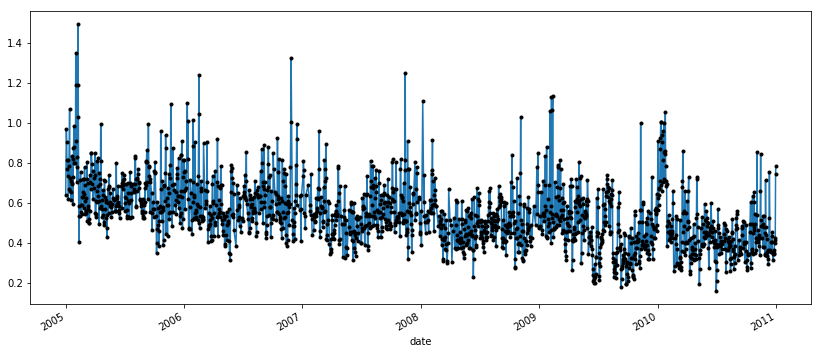

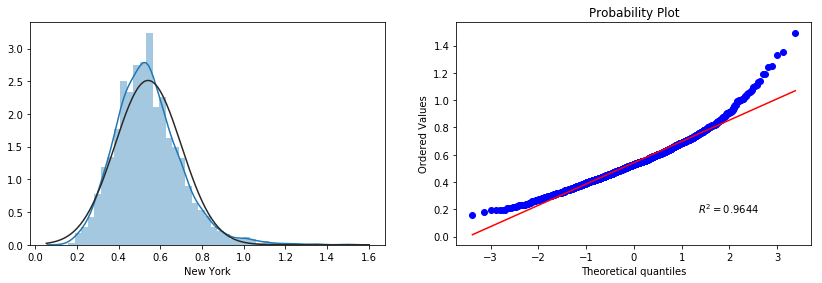

In [9]:
# Time Series Line Plot: _________________________________________
plt.figure(figsize=(14, 6))
TS_NY.plot()
TS_NY.plot(style="k.")
plt.show()

#Time Series Histogram and Density Plot:
fig = plt.figure(figsize=(14, 9))
ax1 = fig.add_subplot(221)
ax1=sns.distplot(TS_NY, fit=stats.norm)
    
ax2 = fig.add_subplot(222)
res=stats.probplot(TS_NY, plot=ax2, rvalue=True)

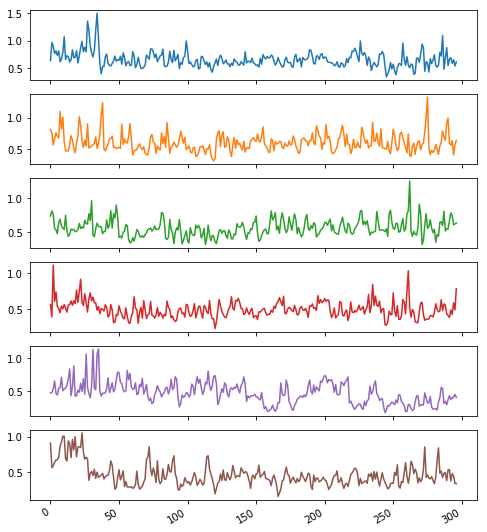

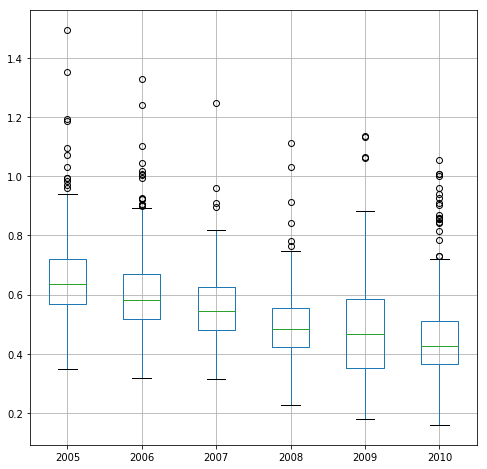

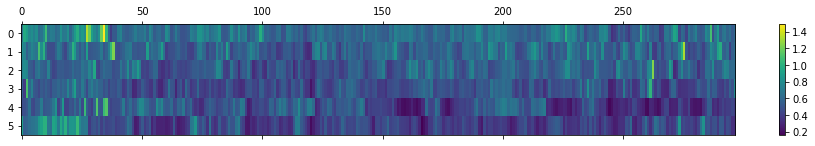

In [10]:
# Time Series Line, Box and Whisker Plots by Intervals: _________________________________________________
from pandas import Series
from pandas import DataFrame
from pandas import TimeGrouper

groups = TS_NY.groupby(TimeGrouper('Y'))
years = DataFrame()

for name, group in groups:
    years[ name.year]=group.values[0:297]
    
years.plot(subplots=True, legend=False, figsize=(8,10))
plt.show()

years.boxplot(figsize=(8,8))
plt.show()

plt.matshow(years.T, interpolation=None, aspect='auto')
plt.colorbar()
plt.show()

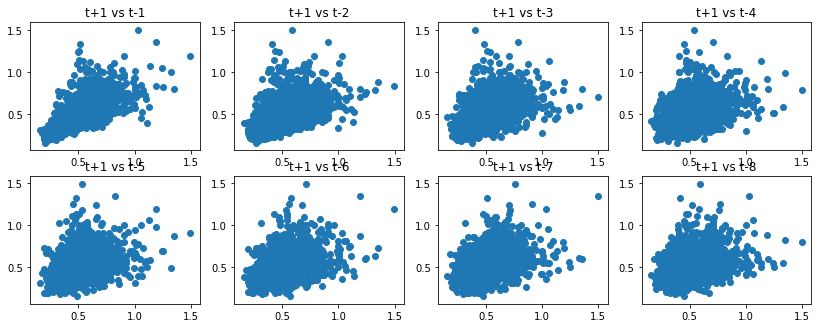

In [11]:
# Time Series Lag Scatter Plots: ____________________________________________________
from pandas import concat
from pandas.plotting import scatter_matrix

plt.figure(figsize=(14, 8))

values = DataFrame(TS_NY.values)
lags = 8
columns = [values]
for i in range(1,(lags + 1)):
    columns.append(values.shift(i))
dataframe = concat(columns, axis=1)
columns = ['t+1']

for i in range(1,(lags + 1)):
    columns.append('t-' + str(i))
dataframe.columns = columns
plt.figure(1)

for i in range(1,(lags + 1)):
    ax = plt.subplot(340 + i)
    ax.set_title('t+1 vs t-' + str(i))
    plt.scatter(x=dataframe['t+1'].values, y=dataframe['t-'+str(i)].values)

plt.show()

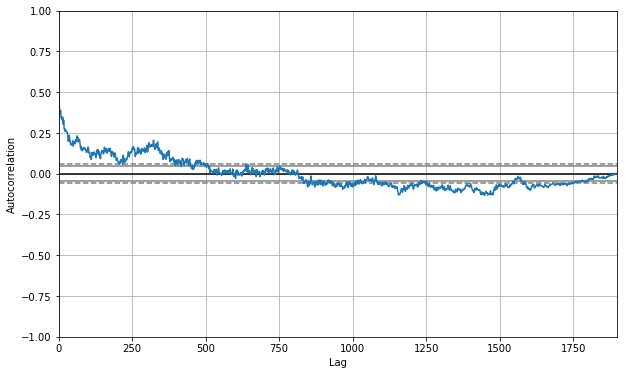

In [12]:
#Time Series Autocorrelation Plot: ________________________________________________________
from pandas.tools.plotting import autocorrelation_plot

plt.figure(figsize=(10, 6))
autocorrelation_plot(TS_NY)
plt.show()

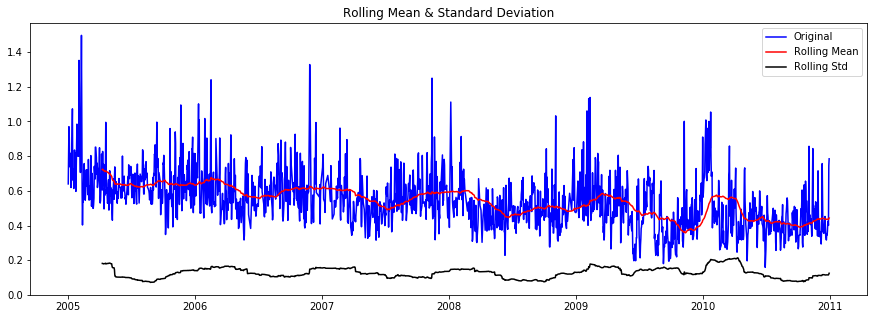

Results of Dickey-Fuller Test:
Test Statistic                   -4.874194
p-value                           0.000039
#Lags Used                       16.000000
Number of Observations Used    1881.000000
Critical Value (1%)              -3.433831
Critical Value (5%)              -2.863078
Critical Value (10%)             -2.567589
dtype: float64


In [13]:
# To check the stationarity of Time Series: _________________________________________________
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries, win=12):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=win).mean()
    rolstd = timeseries.rolling(window=win).std()

    #Plot rolling statistics:
    plt.figure(figsize=(15, 5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
        
    print(dfoutput)
    
    
test_stationarity(TS_NY, win=90)

In [14]:
# prepare the data (i.e. convert problem to a supervised ML problem)
def prepare_data(data, lags=1):
    """
    Create lagged data from an input time series
    """
    X, y = [], []
    for row in range(len(data) - lags - 1):
        a = data[row:(row + lags), 0]
        X.append(a)
        y.append(data[row + lags, 0])
    return np.array(X), np.array(y)

In [15]:
# normalize the dataset
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(pd.DataFrame(TS_NY.values))
 
# split into train and test sets
train = dataset[0:1200, :]
test = dataset[1200:, :]

In [16]:
# LSTM RNN model: _________________________________________________________________
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Dropout, average, Input, merge, concatenate
from keras.layers.merge import concatenate
from keras.regularizers import l2, l1
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils.class_weight import compute_sample_weight
from keras.layers.normalization import BatchNormalization

np.random.seed(42)
rn.seed(42)
tf.set_random_seed(42)

# reshape into X=t and Y=t+1
lags = 2
X_train, y_train = prepare_data(train, lags)
X_test, y_test = prepare_data(test, lags)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], lags, 1))
X_test = np.reshape(X_test, (X_test.shape[0], lags, 1))

# create and fit the LSTM network
mdl = Sequential()
mdl.add(Dense(10, input_shape=(lags, 1), activation='relu'))
mdl.add(LSTM(20, activation='relu'))
#mdl.add(Dense(50, activation='relu'))
mdl.add(Dense(1))

mdl.compile(loss='mean_squared_error', optimizer='adam')
monitor=EarlyStopping(monitor='loss', min_delta=0.001, patience=20, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="air_quality_NY_weights.hdf5", verbose=0, save_best_only=True) # save best model

history=mdl.fit(X_train, y_train, epochs=20, batch_size=1, validation_data=(X_test, y_test),
                                                         callbacks=[monitor, checkpointer], verbose=0)
mdl.load_weights('air_quality_NY_weights.hdf5') # load weights from best model

# To measure RMSE and evaluate the RNN model:
from sklearn.metrics import mean_squared_error

# make predictions
train_predict = mdl.predict(X_train)
test_predict = mdl.predict(X_test)
 
# invert transformation
train_predict = scaler.inverse_transform(pd.DataFrame(train_predict))
y_train = scaler.inverse_transform(pd.DataFrame(y_train))
test_predict = scaler.inverse_transform(pd.DataFrame(test_predict))
y_test = scaler.inverse_transform(pd.DataFrame(y_test))
 
# calculate root mean squared error
train_score = math.sqrt(mean_squared_error(y_train, train_predict[:,0]))
print('Train Score: {:.2f} RMSE'.format(train_score))
test_score = math.sqrt(mean_squared_error(y_test, test_predict[:,0]))
print('Test Score: {:.2f} RMSE'.format(test_score))

Train Score: 0.13 RMSE
Test Score: 0.12 RMSE


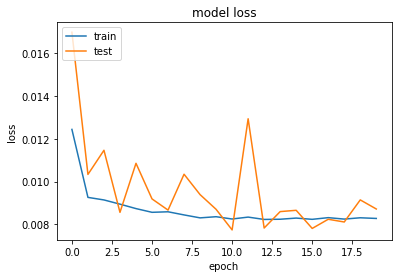

In [17]:
# list all data in history
#print(history.history.keys())

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

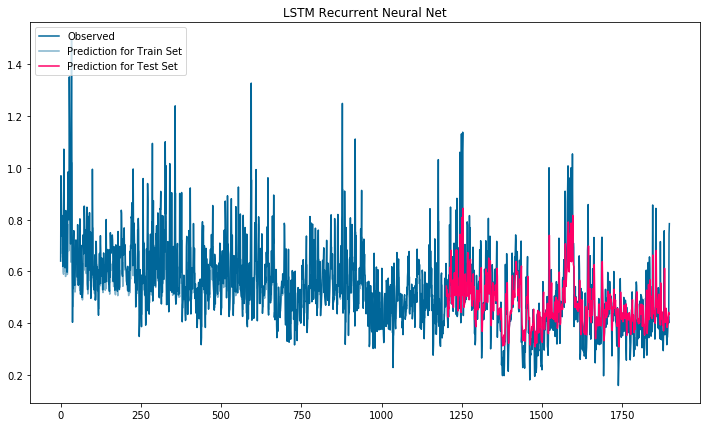

In [18]:
# shift train predictions for plotting
train_predict_plot =np.full(pd.DataFrame(TS_NY.values).shape, np.nan)
train_predict_plot[lags:len(train_predict)+lags, :] = train_predict
 
# shift test predictions for plotting
test_predict_plot =np.full(pd.DataFrame(TS_NY.values).shape, np.nan)
test_predict_plot[len(train_predict) + (lags * 2)+1:len(pd.DataFrame(TS_NY.values))-1, :] = test_predict
 
# plot observation and predictions
plt.figure(figsize=(12,7))
plt.plot(pd.DataFrame(TS_NY.values), label='Observed', color='#006699');
plt.plot(train_predict_plot, label='Prediction for Train Set', color='#006699', alpha=0.5);
plt.plot(test_predict_plot, label='Prediction for Test Set', color='#ff0066');
plt.legend(loc='upper left')

plt.title('LSTM Recurrent Neural Net')
plt.show()

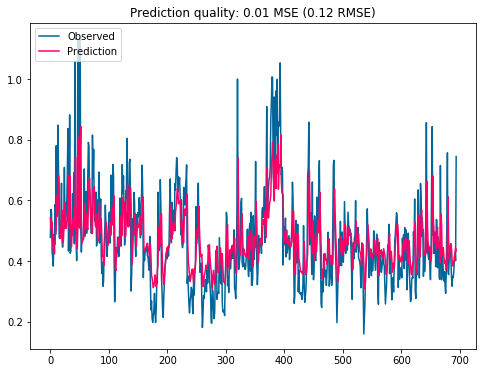

In [19]:
plt.figure(figsize=(8,6))
mse = mean_squared_error(y_test, test_predict[:,0])
plt.title('Prediction quality: {:.2f} MSE ({:.2f} RMSE)'.format(mse, math.sqrt(mse)))
plt.plot(y_test.reshape(-1, 1), label='Observed', color='#006699')
plt.plot(test_predict.reshape(-1, 1), label='Prediction', color='#ff0066')
plt.legend(loc='upper left');

plt.show()